# Alzheimer's MRI Image Classification

Machine learning nowadays has a great potential to enhance healthcare. Our goal is to train a model to diagnose dementia level of an Alzheimer's patients from their MRI images.

We trained the MRI image classifier model which data is obtained from Kaggle. We obtained 96% accruacy and achieved 0.99 ROC AUC score in the validation set. Train-val-test label distribution are as follows:

```
  - train/validation
      - NonDemented (2560 images)
      - VeryMildDemented (1792 images)
      - MildDemented (717 images)
      - ModerateDemented (52 images)
  - test
      - NonDemented (640 images)
      - VeryMildDemented (448 images)
      - MildDemented (179 images)
      - ModerateDemented (12 images)
```



## Install and Imports

In [3]:
#install fastai2
!pip install -Uqq fastbook wandb
import fastbook

     |████████████████████████████████| 727kB 6.8MB/s 
     |████████████████████████████████| 1.8MB 13.7MB/s 
     |████████████████████████████████| 194kB 36.4MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 1.2MB 36.2MB/s 
     |████████████████████████████████| 102kB 14.9MB/s 
     |████████████████████████████████| 133kB 49.2MB/s 
     |████████████████████████████████| 174kB 50.8MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 61kB 11.0MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 


In [4]:
#imports
from fastbook import *
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.wandb import WandbCallback

import glob
import zipfile
import numpy as np
import pandas as pd

## Dataset from Repository

Get dataset from [Pinkshepz/Alzheimers-Class](https://github.com/Pinkshepz/Alzheimers-Class). MRI images dataset are downloaded from [kaggle.com/alzheimers-dataset-4-class-of-images](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images).

In [5]:
!wget --no-check-certificate \
    "https://github.com/Pinkshepz/Alzheimers-Class/archive/refs/heads/main.zip" \
    -O "/content/alzheimers-image.zip"


zip_ref = zipfile.ZipFile('/content/alzheimers-image.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

--2021-06-28 17:06:31--  https://github.com/Pinkshepz/Alzheimers-Class/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/Pinkshepz/Alzheimers-Class/zip/refs/heads/main [following]
--2021-06-28 17:06:31--  https://codeload.github.com/Pinkshepz/Alzheimers-Class/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/alzheimers-image.zip’

/content/alzheimers     [      <=>           ]  34.18M  29.6MB/s    in 1.2s    

2021-06-28 17:06:33 (29.6 MB/s) - ‘/content/alzheimers-image.zip’ saved [35843647]



## Prepare Train/Val Set

In [6]:
#create train/val file names and classes dataframe 
base_dirtr = '/content/Alzheimers-Class-main/Image-dataset/train/'
train_fnames = pd.DataFrame(columns=['fname', 'class'])
class_names = ['NonDemented', 'VeryMildDemented', 
               'MildDemented', 'ModerateDemented']

for class_ in class_names:
  fnames = glob.glob(base_dirtr + class_ + '/*.jpg')
  fnames_df = pd.DataFrame({'fname': fnames, 
                            'class': [class_]*len(fnames)})
  train_fnames = pd.concat([train_fnames, fnames_df], ignore_index=True)

In [7]:
#preview train set dataframe
train_fnames

,fname,class
0,/content/Alzheimers-Class-main/Image-dataset/train/NonDemented/nonDem1520.jpg,NonDemented
1,/content/Alzheimers-Class-main/Image-dataset/train/NonDemented/nonDem995.jpg,NonDemented
2,/content/Alzheimers-Class-main/Image-dataset/train/NonDemented/nonDem2187.jpg,NonDemented
3,/content/Alzheimers-Class-main/Image-dataset/train/NonDemented/nonDem502.jpg,NonDemented
4,/content/Alzheimers-Class-main/Image-dataset/train/NonDemented/nonDem1095.jpg,NonDemented
...,...,...
5116,/content/Alzheimers-Class-main/Image-dataset/train/ModerateDemented/moderateDem20.jpg,ModerateDemented
5117,/content/Alzheimers-Class-main/Image-dataset/train/ModerateDemented/moderateDem45.jpg,ModerateDemented
5118,/content/Alzheimers-Class-main/Image-dataset/train/ModerateDemented/moderateDem47.jpg,ModerateDemented
5119,/content/Alzheimers-Class-main/Image-dataset/train/ModerateDemented/moderateDem8.jpg,ModerateDemented


In [8]:
#preview classes size
train_fnames.groupby(['class']).size().reset_index()

,class,0
0,MildDemented,717
1,ModerateDemented,52
2,NonDemented,2560
3,VeryMildDemented,1792


Since the data among classes is imbalanced, so using accuracy as the metric is not a great choice. We will be using ROC AUC score which is insensitive to unbalanced sample. 

A high ROC AUC score--closer to 1--indicates that the different classes can be distinguishable for the model. In the other hand, a lower score means that the the model cannot distinguish between different classes.

## Create Dataloaders

In [78]:
#randomly split train-val sets with train:val = 80:20
splitter = RandomSplitter(valid_pct=0.2, seed=42)

In [10]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x is an image; y is a single class
    get_x=ColReader(0), #x - image
    get_y=ColReader(1), #y - single class
    splitter=splitter, #split train-val
    item_tfms=Resize(224, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=224,),
    )

In [11]:
dls = dblock.dataloaders(train_fnames, path='.', bs=64) #batch size is 64 

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


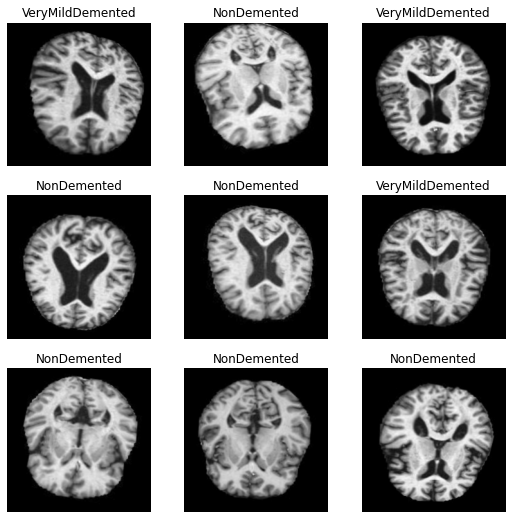

In [12]:
#preview some images
dls.train.show_batch(max_n=9, nrows=3)

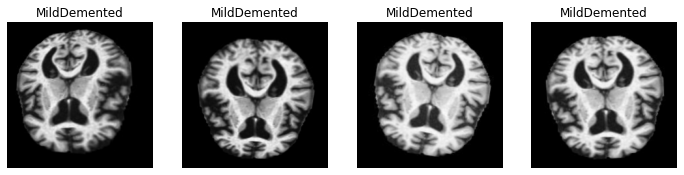

In [13]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Train Model

We utilize `resnet50` to train the model.



In [35]:
model = cnn_learner(dls, 
                    resnet50, 
                    metrics=[accuracy,
                             RocAuc()]).to_fp16()

Let's find learning rate.

SuggestedLRs(valley=tensor(0.0025))

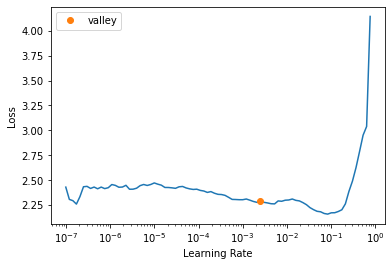

In [15]:
model.lr_find()

We find that `3e-2` seems like a good base learning rate.

We train for 1 epoch with only the head layer and 50 epochs with all layers.

In [38]:
model.fine_tune(epochs=50,
                 base_lr=3e-2, #max learning rate
                 freeze_epochs=1, #epoch num to train frozen
                 lr_mult=100,
                 pct_start=0.2, 
                 div=5.0,     
                 cbs=[SaveModelCallback(monitor='roc_auc_score'),])

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.988806,1.332773,0.527344,0.826418,00:24


Better model found at epoch 0 with roc_auc_score value: 0.8264175599032815.


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.842743,1.777308,0.560547,0.836296,00:28
1,0.752947,0.793850,0.686523,0.880963,00:28
2,0.678683,2.355713,0.653320,0.874855,00:28
3,0.625423,1.333378,0.711914,0.904735,00:28
4,0.608131,1.093000,0.724609,0.911491,00:28
5,0.626994,0.725958,0.692383,0.918710,00:28
6,0.600800,1.953560,0.599609,0.865882,00:28
7,0.618797,2.322165,0.652344,0.876309,00:28
8,0.573038,1.652340,0.770508,0.923644,00:28
9,0.515951,1.486232,0.585938,0.928786,00:28


Better model found at epoch 0 with roc_auc_score value: 0.8362960278268229.
Better model found at epoch 1 with roc_auc_score value: 0.8809627865626611.
Better model found at epoch 3 with roc_auc_score value: 0.9047353233302722.
Better model found at epoch 4 with roc_auc_score value: 0.9114909123354025.
Better model found at epoch 5 with roc_auc_score value: 0.9187102152327662.
Better model found at epoch 8 with roc_auc_score value: 0.9236441350132207.
Better model found at epoch 9 with roc_auc_score value: 0.9287857476340786.
Better model found at epoch 11 with roc_auc_score value: 0.9681905674213059.
Better model found at epoch 12 with roc_auc_score value: 0.9724420802377963.
Better model found at epoch 14 with roc_auc_score value: 0.9836523525278321.
Better model found at epoch 17 with roc_auc_score value: 0.9862722351976667.
Better model found at epoch 20 with roc_auc_score value: 0.9870375093564957.
Better model found at epoch 22 with roc_auc_score value: 0.9883542642561984.
Better

Plot train and validation losses.

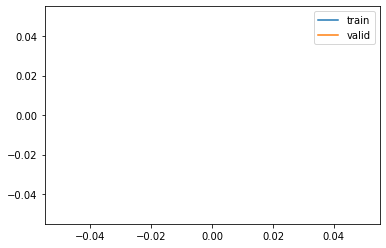

In [120]:
model.recorder.plot_loss()

Learning rate schedule, starting from base learning rate to max learning rate then gradually decreasing to zero.

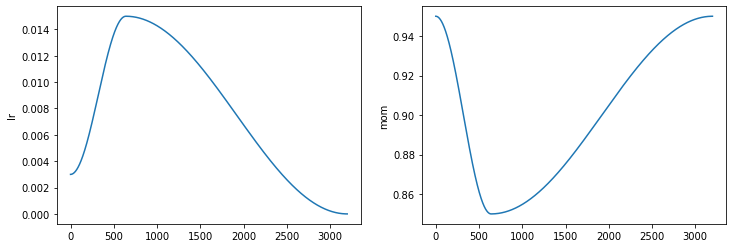

In [112]:
model.recorder.plot_sched()

Create fastai interpretation object to check validation results.

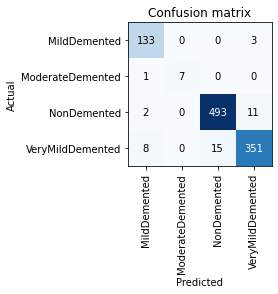

In [40]:
interp = ClassificationInterpretation.from_learner(model)
interp.plot_confusion_matrix()

Preview images with top losses.

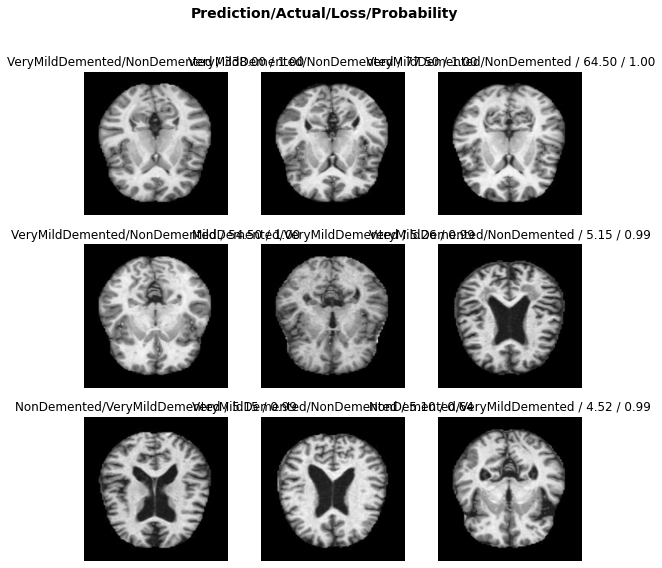

In [41]:
interp.plot_top_losses(9, nrows=3)

In [44]:
interp.print_classification_report()

                  precision    recall  f1-score   support

    MildDemented       0.92      0.98      0.95       136
ModerateDemented       1.00      0.88      0.93         8
     NonDemented       0.97      0.97      0.97       506
VeryMildDemented       0.96      0.94      0.95       374

        accuracy                           0.96      1024
       macro avg       0.96      0.94      0.95      1024
    weighted avg       0.96      0.96      0.96      1024



In [85]:
model.export()

## Test Set Evaluation

Prepare test dataset

In [93]:
base_dirtr = '/content/Alzheimers-Class-main/Image-dataset/test/'
test_fnames = pd.DataFrame(columns=['fname', 'class'])

for class_ in class_names:
  fnames = glob.glob(base_dirtr + class_ + '/*.jpg')
  fnames_df = pd.DataFrame({'fname': fnames, 
                            'class': [class_]*len(fnames)})
  test_fnames = pd.concat([test_fnames, fnames_df], ignore_index=True)

In [94]:
#preview test set dataframe
test_fnames

,fname,class
0,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/29 (11).jpg,NonDemented
1,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/28 (61).jpg,NonDemented
2,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/26 (69).jpg,NonDemented
3,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/27 (93).jpg,NonDemented
4,/content/Alzheimers-Class-main/Image-dataset/test/NonDemented/31 (20).jpg,NonDemented
...,...,...
1274,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/28.jpg,ModerateDemented
1275,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/31 (2).jpg,ModerateDemented
1276,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/29.jpg,ModerateDemented
1277,/content/Alzheimers-Class-main/Image-dataset/test/ModerateDemented/29 (2).jpg,ModerateDemented


In [95]:
#preview sizes of test set classes
test_fnames.groupby(['class']).size().reset_index()

,class,0
0,MildDemented,179
1,ModerateDemented,12
2,NonDemented,640
3,VeryMildDemented,448


In [82]:
#new datablocks and learner
splitter = RandomSplitter(valid_pct=0.99, seed=42)
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x is an image; y is a single class
    get_x=ColReader(0), #x - image
    get_y=ColReader(1), #y - single class
    splitter=splitter,
    item_tfms=Resize(224, method=ResizeMethod.Squish),
    batch_tfms=aug_transforms(size=224,),
    )

dls = dblock.dataloaders(test_fnames, bs=64) #batch size is 64

model_test = cnn_learner(dls, 
                    resnet50, 
                    metrics= [accuracy, RocAuc()]).to_fp16()

#load trained model
model_test.load('model');

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


Test set result

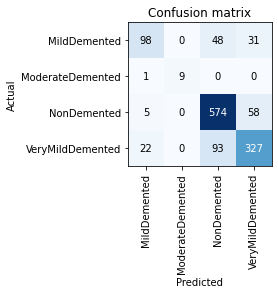

In [102]:
interp = ClassificationInterpretation.from_learner(model_test)
interp.plot_confusion_matrix()

In [84]:
interp.print_classification_report() 

                  precision    recall  f1-score   support

    MildDemented       0.78      0.55      0.65       177
ModerateDemented       1.00      0.90      0.95        10
     NonDemented       0.80      0.90      0.85       637
VeryMildDemented       0.79      0.74      0.76       442

        accuracy                           0.80      1266
       macro avg       0.84      0.77      0.80      1266
    weighted avg       0.80      0.80      0.79      1266



In [111]:
#calculate model's accuracy and AUC ROC score as the metrics
def auc_score(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score, multi_class='ovo'))

probs,val_labels = model_test.get_preds()
print("AUC ROC score is " + str("%.2f" % float(auc_score(probs, val_labels))))
print("Accuracy is " + str("%.2f" % float(accuracy(probs, val_labels))))

AUC ROC score is 0.93
Accuracy is 0.80
